In [1]:
import pandas as pd
import numpy as np
from cytoolz import identity, concat, merge, merge_with
from collections import Counter
from adjustText import adjust_text
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from scipy.cluster import hierarchy
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import *
from sklearn.preprocessing import *
from sklearn.cluster import *
from sklearn.decomposition import *
from sklearn.manifold import *

In [3]:
ents = pd.read_msgpack('https://bit.ly/2CI0J2V')

In [4]:
ents[:5]

((('Gary Null', 'PERSON'), ('2hr', 'ORDINAL')),
 (('Third', 'ORDINAL'), ('Suez - Israel', 'ORG'), ('Sri Lanka', 'GPE')),
 (('Reddit', 'ORG'),),
 (('Skilluminati - The Rosetta Stone', 'ORG'),
  ('M.O. - Concentrate', 'ORG'),
  ('Quigley', 'ORG'),
  ('Elite', 'GPE'),
  ('Tragedy and Hope', 'WORK_OF_ART')),
 (('the White House', 'ORG'),))

In [5]:
ents = [[x for x, y in e if y not in ['CARDINAL', 'ORDINAL', 'DATE', 'TIME', 'PERCENT', 'QUANTITY', 'MONEY']]
       for e in ents]

In [6]:
ents[:5]

[['Gary Null'],
 ['Suez - Israel', 'Sri Lanka'],
 ['Reddit'],
 ['Skilluminati - The Rosetta Stone',
  'M.O. - Concentrate',
  'Quigley',
  'Elite',
  'Tragedy and Hope'],
 ['the White House']]

In [7]:
freq = Counter(concat(ents))

In [8]:
freq.most_common(10)

[('US', 60347),
 ('American', 31713),
 ('Trump', 31384),
 ('America', 29762),
 ('Obama', 29134),
 ('CIA', 27874),
 ('Israel', 25559),
 (' ', 24397),
 ('Russia', 24093),
 ('U.S.', 21156)]

In [275]:
dtm = CountVectorizer(analyzer = identity, binary = True, max_features = 100)

In [276]:
D = dtm.fit_transform(ents)

In [277]:
D.shape

(390034, 100)

In [278]:
labels = dtm.get_feature_names()

In [549]:
len(labels)

100

In [279]:
T = D.T * D

In [280]:
T.shape

(100, 100)

In [15]:
clusters = AgglomerativeClustering(n_clusters=4).fit_predict(T.toarray())

In [16]:
for cl in set(clusters):
    print(cl, ', '.join((np.array(labels)[(clusters)==cl])))

0   , Afghanistan, Alex Jones, Bernie, British, Bush, CNN, California, Canada, China, Chinese, Christian, Christians, Congress, DNC, Democrats, Donald Trump, EU, Earth, English, Europe, European, Facebook, France, French, GOP, German, Germany, Google, Hillary Clinton, Hitler, Hollywood, IMO, ISIS, Iran, Iraq, Islamic, Israeli, JFK, Japan, Jew, Jewish, Jews, Libya, Lol, MSM, Muslim, Muslims, NASA, NATO, NP, NSA, NWO, Nazi, New York, OP, Pentagon, Putin, Reddit, Republican, Republicans, Russians, Saudi Arabia, Snowden, State, Syria, Syrian, TPTB, Texas, UK, UN, USA, Ukraine, WTC, Washington, West, Wikileaks, YouTube, Zionist, Zionists, earth, np.reddit.com, the Middle East, the United States, the White House
1  , Americans, CIA, Clinton, FBI, Hillary, Israel, Obama, Russia, Russian, Trump, U.S.
2 US
3 America, American


In [17]:
Z = hierarchy.linkage(T.toarray(), 'ward')

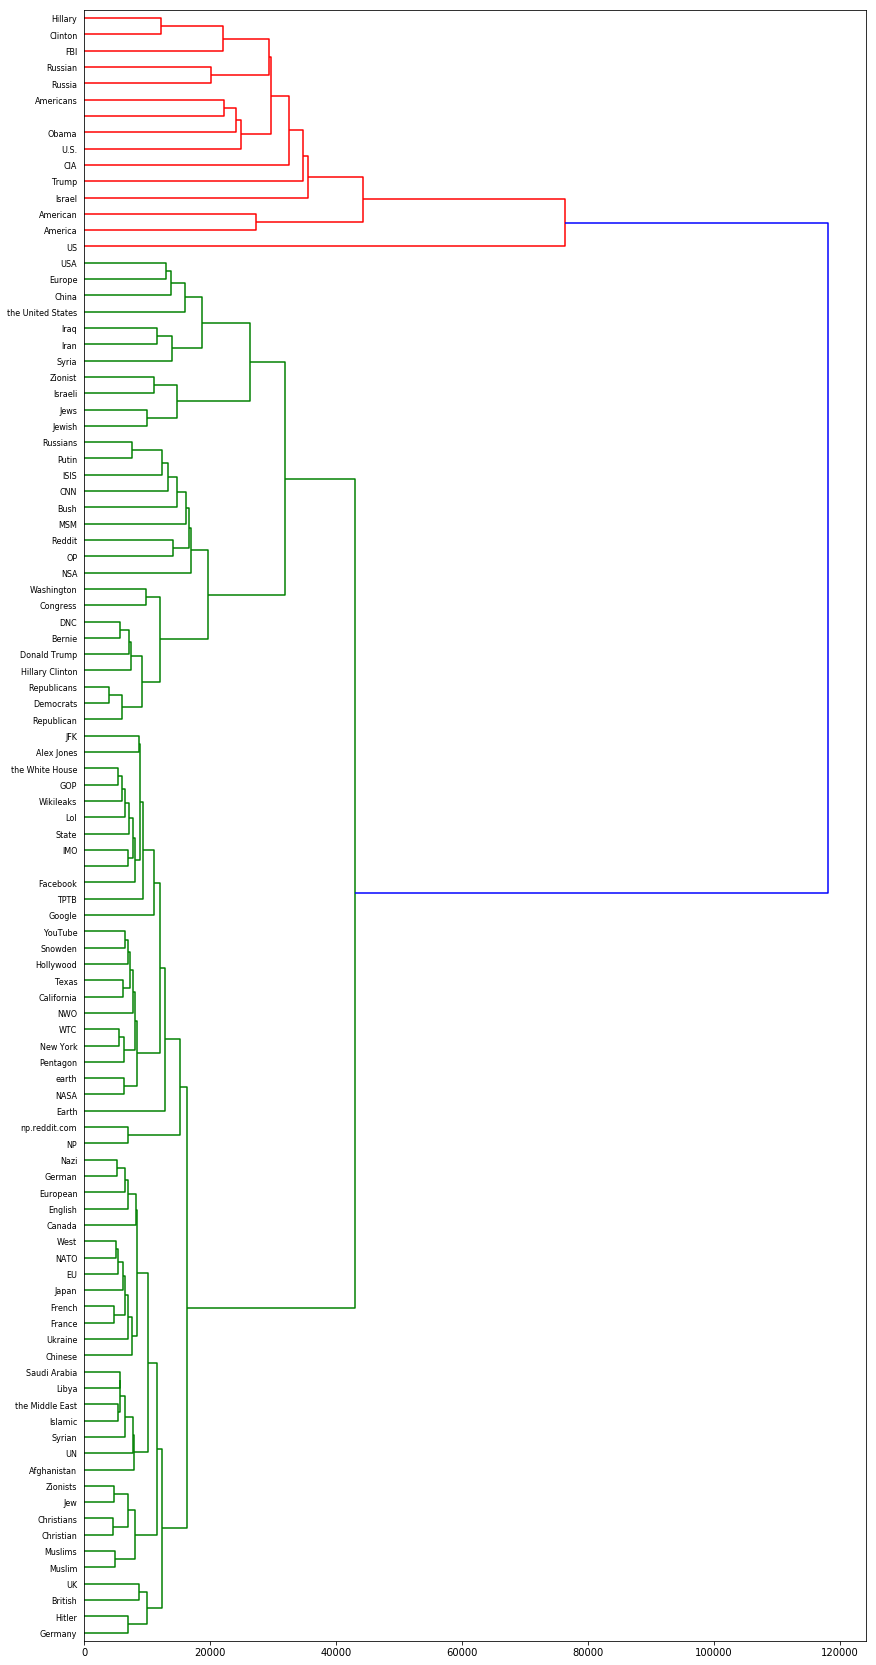

In [18]:
plt.figure(figsize=(14,30))
hierarchy.dendrogram(Z, labels=labels, orientation='right', leaf_font_size=8)
plt.show()

In [19]:
reduce = make_pipeline(TruncatedSVD(20),
                       TSNE(2, perplexity=50, learning_rate=50, early_exaggeration=50))
xy = reduce.fit_transform(T.toarray())

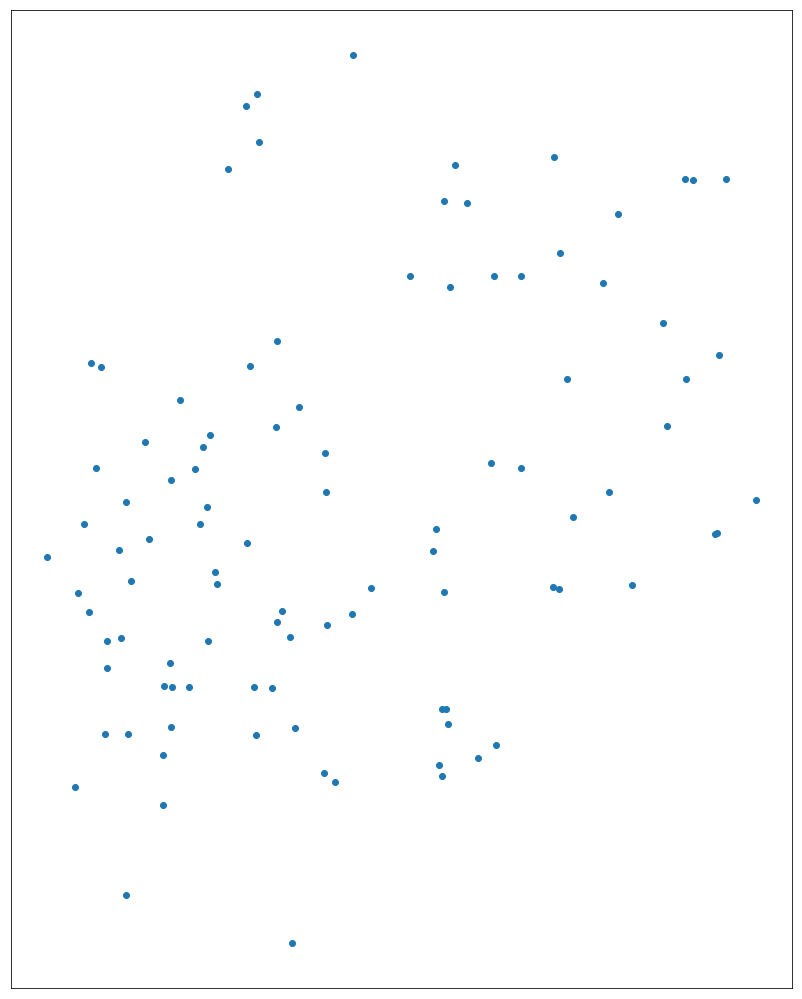

In [20]:
plt.figure(figsize=(14,18))
plt.scatter(xy[:,0], xy[:,1])
plt.xticks([], [])
plt.yticks([], [])
plt.show()

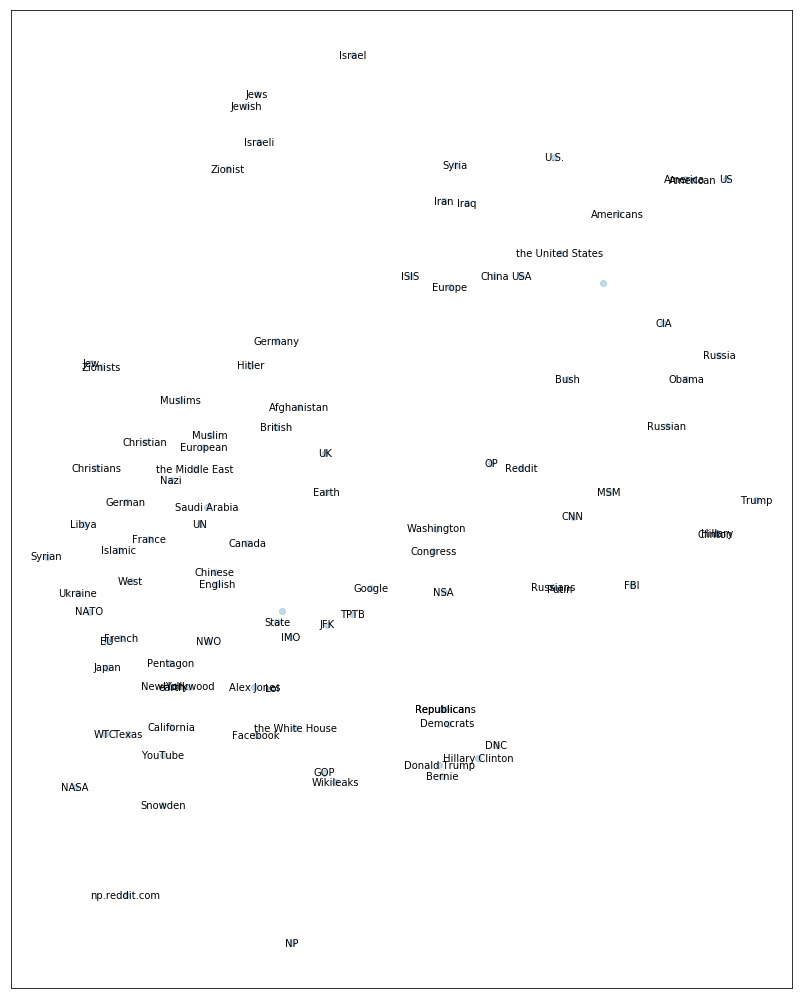

In [21]:
plt.figure(figsize=(14,18))
plt.scatter(xy[:,0], xy[:,1], alpha=0.25)
for x, y, t in zip(xy[:,0], xy[:,1], labels):
    plt.text(x, y, t, ha='center', va='center')
plt.xticks([], [])
plt.yticks([], [])
plt.show()

#### Findings 1

Words located closely related to each other. By 'Jews', 'Jewish', and 'Israeli' adjacent to 'Zionist', I would conclude that 'Zionist' is kind of jewish group. With 'Google' right next to 'TPTB', I would investigate the word leveraging 'Google.' In contrast, there were incorrect tokenization, which led some duplicates, resulting in 'Hilary Clinton', and 'Hilary' located far away.

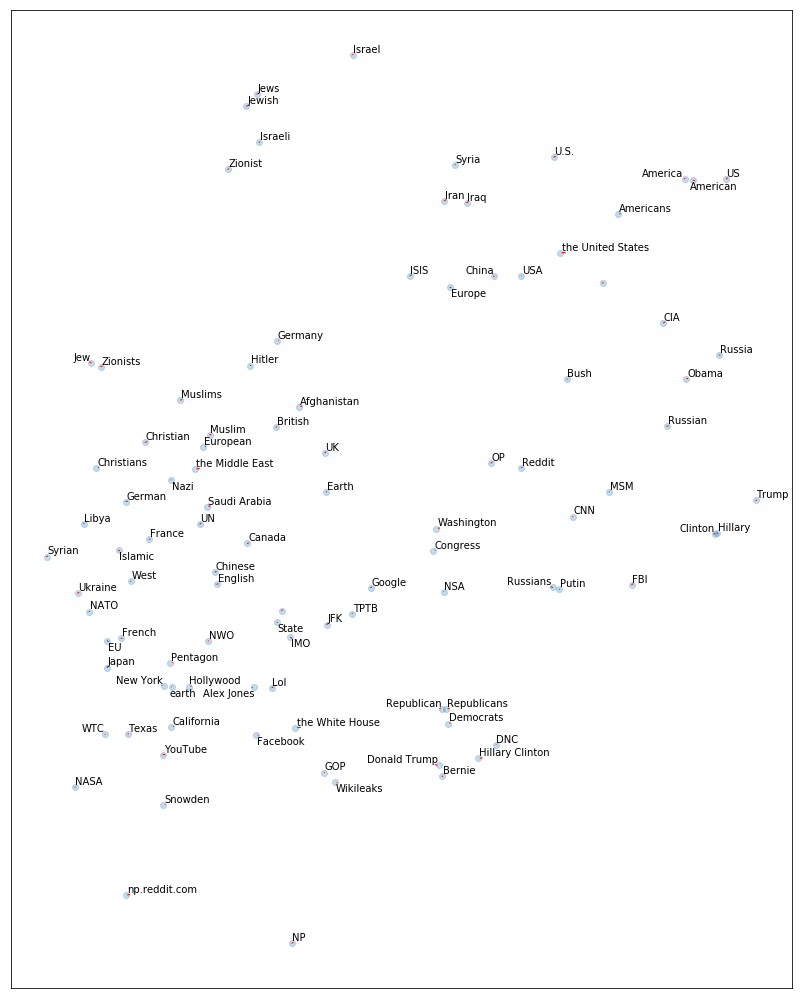

In [34]:
plt.figure(figsize=(14,18))
plt.scatter(xy[:,0], xy[:,1], alpha=0.25)
text = [plt.text(x, y, t, ha='center', va='center') for x, y, t in zip(xy[:,0], xy[:,1], labels)]
adjust_text(text, arrowprops=dict(arrowstyle='-', color='red'))
plt.xticks([], [])
plt.yticks([], [])
plt.show()

In [23]:
A = AffinityPropagation().fit(T)

In [24]:
clusters = dict(zip(labels, A.labels_))
for c in sorted(set(clusters.values())):
    print(c, ':', ', '.join(k for k,v in clusters.items() if v==c))

0 :  
1 : America
2 : American
3 : Americans
4 : CIA
5 : China
6 : Clinton, Hillary
7 : Bernie, Bush, CNN, Congress, DNC, Democrats, Donald Trump, GOP, Hillary Clinton, OP, Putin, Republican, Republicans, Russians, Washington
8 : FBI
9 : Iran, Iraq
10 : Israel
11 : Israeli, Jewish, Jews, Zionist
12 : MSM
13 : NSA
14 : Obama
15 : Reddit
16 : Russia
17 : Russian
18 : Syria
19 : Trump
20 : U.S.
21 : US
22 : USA
23 :   , Afghanistan, Alex Jones, British, California, Canada, Chinese, Christian, Christians, EU, Earth, English, Europe, European, Facebook, France, French, German, Germany, Google, Hitler, Hollywood, IMO, ISIS, Islamic, JFK, Japan, Jew, Libya, Lol, Muslim, Muslims, NASA, NATO, NP, NWO, Nazi, New York, Pentagon, Saudi Arabia, Snowden, State, Syrian, TPTB, Texas, UK, UN, Ukraine, WTC, West, Wikileaks, YouTube, Zionists, earth, np.reddit.com, the Middle East, the White House
24 : the United States


#### Findings 2
Clustered in 1,2, and 3, I would conclude that those 3 words are most commenly used in the conspiracy category. 7th category seems to be related with the last elections. In 11th, it's clear that zionist is related with jews. This affinity propagation can be improved, though, as too many tokens are clusted in 23rd, which would be labeld as 'miscellaneous.'

In [25]:
from sklearn.neighbors import *

In [96]:
neighbors = NearestNeighbors(metric='cosine').fit(D)

In [97]:
V = list(labels)
V

[' ',
 '  ',
 'Afghanistan',
 'Alex Jones',
 'America',
 'American',
 'Americans',
 'Bernie',
 'British',
 'Bush',
 'CIA',
 'CNN',
 'California',
 'Canada',
 'China',
 'Chinese',
 'Christian',
 'Christians',
 'Clinton',
 'Congress',
 'DNC',
 'Democrats',
 'Donald Trump',
 'EU',
 'Earth',
 'English',
 'Europe',
 'European',
 'FBI',
 'Facebook',
 'France',
 'French',
 'GOP',
 'German',
 'Germany',
 'Google',
 'Hillary',
 'Hillary Clinton',
 'Hitler',
 'Hollywood',
 'IMO',
 'ISIS',
 'Iran',
 'Iraq',
 'Islamic',
 'Israel',
 'Israeli',
 'JFK',
 'Japan',
 'Jew',
 'Jewish',
 'Jews',
 'Libya',
 'Lol',
 'MSM',
 'Muslim',
 'Muslims',
 'NASA',
 'NATO',
 'NP',
 'NSA',
 'NWO',
 'Nazi',
 'New York',
 'OP',
 'Obama',
 'Pentagon',
 'Putin',
 'Reddit',
 'Republican',
 'Republicans',
 'Russia',
 'Russian',
 'Russians',
 'Saudi Arabia',
 'Snowden',
 'State',
 'Syria',
 'Syrian',
 'TPTB',
 'Texas',
 'Trump',
 'U.S.',
 'UK',
 'UN',
 'US',
 'USA',
 'Ukraine',
 'WTC',
 'Washington',
 'West',
 'Wikileaks',
 '

In [98]:
V.index('Zionist')

93

In [634]:
neighbors.kneighbors(D[93,:])

(array([[2.22044605e-16, 2.22044605e-16, 2.22044605e-16, 2.22044605e-16,
         2.22044605e-16]]),
 array([[ 60092,  43063, 153219, 126333, 229021]], dtype=int64))

In [789]:
np.shape(ents)

(390034,)

In [790]:
print(type(ents))

<class 'list'>


In [793]:
print(ents[3999])

['The Biometric Database']


In [777]:
get_neighbors('Zionist')


[143444, 232087, 51377, 13621, 31750, 370540, 219990, 245052, 106400, 94181]

In [831]:
def get_neighbors(word, k=10):
    _, terms = neighbors.kneighbors(D[V.index(word)], n_neighbors=k)
    return [ents[t] for t in terms[0]]
#     for t in terms[0]:
#         print(D[t,:])
#     return [D[t] for t in terms[0]]

In [833]:
def get_neighbors(word, k=10):
    _, terms = neighbors.kneighbors(D[V.index(word)], n_neighbors=k)
    for t in terms[0]:
        return ents[t]

In [2]:
def get_neighbors(word, k=10):
    _, terms = neighbors.kneighbors(D[V.index(word)], n_neighbors=k)
    for t in terms[0]:
        print(ents[t])

In [854]:
get_neighbors('TPTB', k=10)

['East Africa', 'France', 'NATO', 'US', 'Russia', 'SURROUND China', 'South West Pacific', 'the Indian Ocean', 'China']
['Self', 'Christians', 'New Age', 'Hindu']
['The Rings Of Saturn Are “Proliferating', 'Giant', 'NASA', 'Ames Research Centre']
['Chloramines', 'Pool Smell" You Think Is Chlorine']
['Photo']
['London']
['Satan', 'CMS', 'Best', 'TrekMovie', 'LMFAO', 'LHC', ' Bottom', 'CCTV', 'faaake](https://www.youtube.com', 'CERN']
['Hillary', 'VA', 'Iraq', 'Ron Paul', 'WTF', 'Jane', 'DC', '> Trump', 'Americans', 'Vermont', 'State', 'Washington DC', 'Hillary', 'Syria', 'Maine', 'Guantanamo Bay', 'Trump', 'Bernie', 'Islamic']
['Machine Gun', 'Judaism', 'COWARDLY', 'Danish', 'Isreal', 'Jews', 'Jewish', 'Israeli']
[' Yeah,', 'Luke', 'Usain Bolt', 'Jamaican', 'MM', 'Usain Bolt', 'Satan', 'heaven', 'Satanic', 'OK', 'Lane', 'Olympics', '3 Races', 'Meter Illuminati Gold', 'Olympic', 'the Satanist Hollywood', 'Games', 'Usian Bolt Wins Relay', 'Jamaica']


#### Findings 3 <p>
    
By analyzing the words positioned near 'TPTB', I can find what concepts are related to 'TPTB', even not knowing what it is. It seems that the 'TPTB' is some kind of an organization related to army or war, which has negative reflection onto Americans.